# Imports and Downloads

In [1]:
import pandas as pd
import numpy as np
import gensim
import gensim.downloader
import matplotlib.pyplot as plt
import tensorflow as tf
import string

from tqdm import tqdm

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
 
from keras.layers import LSTM, Activation, Dropout, Dense, Input, Bidirectional, GRU
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, accuracy_score, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
!wget https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/print_metrics.py

!wget https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/dev.csv
!wget https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/train.csv
!wget https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/augmented.csv
# !wget https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/augmented-all.csv

--2022-05-19 14:37:28--  https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/print_metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1694 (1.7K) [text/plain]
Saving to: ‘print_metrics.py’

print_metrics.py    100%[===================>]   1.65K  --.-KB/s    in 0s      

2022-05-19 14:37:28 (27.5 MB/s) - ‘print_metrics.py’ saved [1694/1694]

--2022-05-19 14:37:29--  https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/dev.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5060506 (4.8M) [text/pl

In [4]:
import print_metrics
# Download
embedding_dim = 50
# glove_vectors = gensim.downloader.load(f'glove-wiki-gigaword-{embedding_dim}') # 50, 100, 200 or 300
glove_vectors = gensim.downloader.load(f'glove-twitter-{embedding_dim}') # 25, 50, 100, 200 or 300

[==================================================] 100.0% 199.5/199.5MB downloaded


# Data exploration

In [5]:
df = pd.read_csv("train.csv")
df = df.drop(["Unnamed: 0"],axis=1)

df_aug = pd.read_csv("augmented.csv", sep='\t')
# df_aug = pd.read_csv("augmented-all.csv", sep='\t')
df_aug['fraudulent'] = np.ones(len(df_aug), dtype=int)
df_aug = df_aug.replace(" ",np.nan)

df_val = pd.read_csv("dev.csv")
df_val = df_val.drop(["Unnamed: 0"],axis=1)

for df_column in df.columns:
    if df_column not in df_aug.columns:
        print("Dropped:", df_column)
        df = df.drop([df_column],axis=1)
        df_val = df_val.drop([df_column],axis=1)

df_aug.head()

Dropped: job_id
Dropped: company_profile


,title,location,department,description,requirements,benefits,employment_type,required_experience,required_education,industry,function,salary_range,telecommuting,has_company_logo,has_questions,fraudulent
0,Client Audit Coordinator,"US, TX, austin Austin",complaisance unit 701,Description SUMMARY: The Client Audit Coordina...,High school diploma or equivalent; Bachelor's ...,we have a flexible and comprehensive range bet...,Part-time,Mid-Senior level,NaN,Financial avail,Sales,NaN,NaN,NaN,NaN,1
1,chief audit coordinator,"United States, TX, Austin",complaisance COMPLIANCE UNIT 701,description summary: the customer audit coordi...,High school diploma or equivalent; Bachelor's ...,We offer a efficient and constructive range pe...,NaN,NaN,High School or equivalent,Financial Services,NaN,NaN,NaN,NaN,NaN,1
2,scrutinize Client Audit Coordinator,"US, TX, austin Austin",COMPLIANCE UNIT unit of measurement 701,Description SUMMARY: The Client Audit Coordina...,High school diploma or equivalent; Bachelor's ...,We offer a competitive and comprehensive range...,Full-time,Associate,Unspecified,Financial Services,Engineering,NaN,NaN,NaN,NaN,1
3,node Audit Coordinator,"US, TX, capital of texas",COMPLIANCE UNIT 653,description summary : the client audit coordin...,Secondary or equivalent degree; Preferred degr...,we offer a competitive and comprehensive scope...,Full-time,Entry level,NaN,fiscal Services,NaN,NaN,NaN,NaN,NaN,1
4,client audit coordinator,"US, TX, austin",conformity UNIT 701,Description SUMMARY: The Client Audit Coordina...,Secondary or equivalent degree; Preferred degr...,We offer a range and comprehensive competitive...,Contract,Associate,NaN,Financial service Services,Sales,NaN,NaN,NaN,NaN,1


#### Missing Values

In [6]:
df_fake = df.loc[df["fraudulent"]==1]
df_true = df.loc[df["fraudulent"]==0]

In [7]:
def getNaNRatio(dataframes, column_names):
    nan_df = pd.DataFrame({
        'features': [column for column in sorted(dataframes[0].columns)]
    })
    for i in range(len(column_names)):
        dataframe = dataframes[i]
        rows = len(dataframe)
        nan_df[column_names[i]] = [round(dataframe[column].isna().sum()/rows, 20) for column in sorted(dataframe.columns)]

    return nan_df

In [8]:
getNaNRatio([df_fake, df_aug, df_true], ['Fake data', 'Fake data augmented', 'True data'])

,features,Fake data,Fake data augmented,True data
0,benefits,0.404402,0.344885,0.401561
1,department,0.610729,0.519268,0.645577
2,description,0.001376,0.002495,0.000000
3,employment_type,0.280605,0.283061,0.191795
4,fraudulent,0.000000,0.000000,0.000000
5,function,0.385144,0.382589,0.360831
6,has_company_logo,0.000000,1.000000,0.000000
7,has_questions,0.000000,1.000000,0.000000
8,industry,0.317744,0.275853,0.273919
9,location,0.019257,0.017466,0.019224


#### Correlation (features with binary value)

In [9]:
# Correlation
df[["telecommuting","fraudulent"]].corr()

,telecommuting,fraudulent
telecommuting,1.00000,0.03296
fraudulent,0.03296,1.00000


In [10]:
df[["has_company_logo","fraudulent"]].corr()

,has_company_logo,fraudulent
has_company_logo,1.000000,-0.264599
fraudulent,-0.264599,1.000000


-0.26 is significant correlation for keeping this feature

In [11]:
df[["has_questions","fraudulent"]].corr()

,has_questions,fraudulent
has_questions,1.000000,-0.092613
fraudulent,-0.092613,1.000000


# Preprocessing

## Fill nan

In [12]:
df = df.fillna("none")
df_aug = df_aug.fillna("none")
df_val = df_val.fillna("none")

## Concatenate Train and Augmented datasets

In [13]:
print('Train dataset length:', len(df))
print('Augmented dataset length:', len(df_aug))

df = pd.concat([df_aug, df])
df = shuffle(df)
df = df.reset_index()

print('Train dataset after concatenation:', len(df))

Train dataset length: 14304
Augmented dataset length: 3607
Train dataset after concatenation: 17911


## Merge Features

In [14]:
def merge(df):
    # df = df.assign(merged_features=lambda df: df["title"]+" "+df["location"]+" "+df["department"]+
    #           df["employment_type"]+" "+df["required_experience"]+" "+df["required_education"]+" "+
    #            df["industry"]+" "+df["function"])
    
    # df = df.assign(merged_features=lambda df: df["description"])
    
    df = df.assign(merged_features=lambda df: 
                   df["title"]+" "
                   +df["location"]+" "
                   +df["department"]+" "
                   +df["description"]+" "
                  #  +df["employment_type"]+" "
                  #  +df["required_experience"]+" "
                  #  +df["required_education"]+" "
                  #  +df["industry"]+" "
                  #  +df["function"]+" "
                  #  +df["requirements"]+" "
                  #  +df["benefits"]
                   )
    

    return df[["merged_features","fraudulent"]]

In [15]:
df_merged = merge(df)
df_val_merged = merge(df_val)
df_merged.head()

,merged_features,fraudulent
0,"Test Engineer NZ, , none We are on the looko...",0
1,"Graphic Designer GR, , none Tutorizon is an o...",0
2,"Lead iOS developer GR, I, Athens none You'll l...",0
3,"Sr. Reservoir Engineer US, CA, San Ramon none ...",0
4,"Operations Room Manager US, MA, capital of ore...",1


In [16]:
features_train = np.array(df_merged["merged_features"])
target_train = np.array(df_merged["fraudulent"])

features_val = np.array(df_val_merged["merged_features"])
target_val = np.array(df_val_merged["fraudulent"])

## Tokenization

In [17]:
# Lowercase, removing stop words, punctuation, numbers, stemming

# Input -> array of docs
def preprocess_texts(texts):
    preprocessed = []
    # stop_words = stopwords.words('english')
    punct=string.punctuation
    # stemmer=PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    print("Preprocessing..")
    for text in tqdm(texts):
        words = word_tokenize(text)
        words = [''.join([i for i in word if not i.isdigit()]) for word in words] # Removing numbers
        # All in one :)
        # words = [lemmatizer.lemmatize(word.lower()) for word in words if (word not in stop_words) and (word not in punct)]
        words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in punct]
        preprocessed.append(words)
        
    print("Done")
    return preprocessed
        

In [18]:
preprocessed_train = preprocess_texts(features_train)
preprocessed_val = preprocess_texts(features_val)
#print(preprocessed[:3])

Preprocessing..


100%|██████████| 17911/17911 [00:37<00:00, 483.62it/s]


Done
Preprocessing..


100%|██████████| 1788/1788 [00:03<00:00, 486.14it/s]

Done


## GloVe Embeddings

In [19]:
def texts2embeddings(texts, max_length, em_dim):
    zero_vector = np.zeros(em_dim)
    embeddings = []
    total_words = 0
    missing_words = 0
    for text in tqdm(texts):
        embedded_text = []
        for word in text:
            total_words += 1
            try:
                embedded_text.append(glove_vectors[word])
            except:
                # embedded_text.append(zero_vector)
                embedded_text.append(glove_vectors['unk'])
                missing_words += 1
        embeddings.append(embedded_text)
    embeddings = pad_sequences(embeddings, maxlen=max_length, padding='post',value=zero_vector,dtype="float32")
    print("Missing words:",missing_words/total_words)
    return embeddings

In [20]:
max_input_length = max([len(doc) for doc in preprocessed_train]) 
print("Max length:", max_input_length)
max_input_length=1000

embedded_features_train = texts2embeddings(preprocessed_train,max_input_length,embedding_dim)
embedded_features_val = texts2embeddings(preprocessed_val,max_input_length,embedding_dim)

Max length: 6882


100%|██████████| 17911/17911 [00:05<00:00, 3337.50it/s]


Missing words: 0.05293722911255497


100%|██████████| 1788/1788 [00:00<00:00, 3575.32it/s]


Missing words: 0.05543104918272393


*Uncomment next cells if session crashes in colab:*

In [21]:
# with open('embedded_features_train.npy', 'wb') as f:
#     np.save(f, embedded_features_train)
# with open('embedded_features_val.npy', 'wb') as f:
#     np.save(f, embedded_features_val)

In [22]:
# with open('embedded_features_train.npy', 'rb') as f:
#     embedded_features_train = np.load(f)
# with open('embedded_features_val.npy', 'rb') as f:
#     embedded_features_val = np.load(f)

# Training the Neural Network

In [23]:
from functools import lru_cache
# Building model

checkpoint_filepath = './checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


model = Sequential()
model.add(Bidirectional(LSTM(300, input_shape=(max_input_length, embedding_dim))))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(Dense(1,activation="sigmoid")) 
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=["accuracy"])
history = model.fit(embedded_features_train, target_train, epochs=30, batch_size=32, verbose=2,
                    validation_data=(embedded_features_val,target_val), callbacks=[model_checkpoint_callback])

Epoch 1/30
560/560 - 75s - loss: 0.3575 - accuracy: 0.8446 - val_loss: 0.1295 - val_accuracy: 0.9592 - 75s/epoch - 134ms/step
Epoch 2/30
560/560 - 70s - loss: 0.5284 - accuracy: 0.7681 - val_loss: 0.2075 - val_accuracy: 0.9396 - 70s/epoch - 125ms/step
Epoch 3/30
560/560 - 70s - loss: 0.3393 - accuracy: 0.8577 - val_loss: 0.1722 - val_accuracy: 0.9631 - 70s/epoch - 126ms/step
Epoch 4/30
560/560 - 70s - loss: 0.2653 - accuracy: 0.8919 - val_loss: 0.1676 - val_accuracy: 0.9368 - 70s/epoch - 126ms/step
Epoch 5/30
560/560 - 70s - loss: 0.1810 - accuracy: 0.9301 - val_loss: 0.1502 - val_accuracy: 0.9402 - 70s/epoch - 125ms/step
Epoch 6/30
560/560 - 70s - loss: 0.1317 - accuracy: 0.9490 - val_loss: 0.0966 - val_accuracy: 0.9659 - 70s/epoch - 126ms/step
Epoch 7/30
560/560 - 70s - loss: 0.0957 - accuracy: 0.9631 - val_loss: 0.0791 - val_accuracy: 0.9765 - 70s/epoch - 126ms/step
Epoch 8/30
560/560 - 70s - loss: 0.0734 - accuracy: 0.9720 - val_loss: 0.0831 - val_accuracy: 0.9732 - 70s/epoch - 126

In [24]:
print("Baseline:",(1-sum(target_val)/len(target_val)))

Baseline: 0.9619686800894854


Max threshold 0.8
Accuracy: 0.98
F1:
Micro: 0.98
Macro: 0.88
Weighted: 0.98
For fraudulent: 0.76


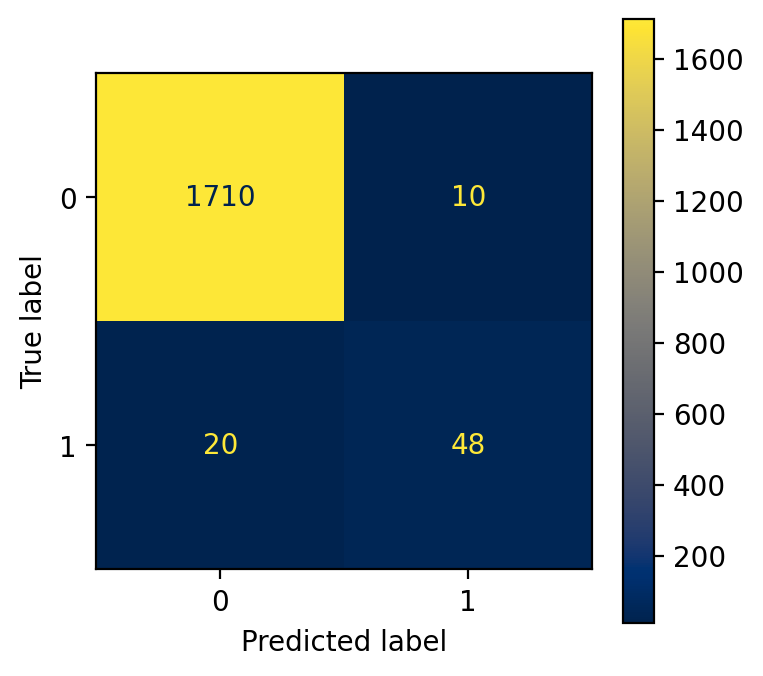

In [25]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

predicted = model.predict(embedded_features_val)
print_metrics.calculate_analog_results(target_val, predicted)

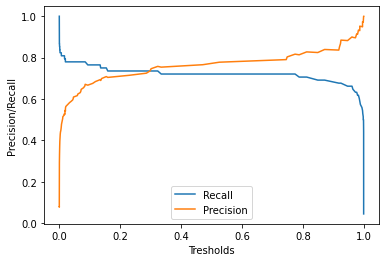

In [26]:
# Presicion / recall curve
precision,recall,tresholds = precision_recall_curve(target_val, predicted)

plt.plot(tresholds,recall[:-1],label="Recall")
plt.plot(tresholds,precision[:-1],label="Precision")
plt.xlabel("Tresholds")
plt.ylabel("Precision/Recall")
plt.legend()
plt.show()

# Training Classical ML Models

## Random Forest Classifier

In [27]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(embedded_features_train.reshape(len(df), -1), target_train)

RandomForestClassifier(random_state=0)

Accuracy: 0.98
F1:
Micro: 0.98
Macro: 0.79
Weighted: 0.97
For fraudulent: 0.58


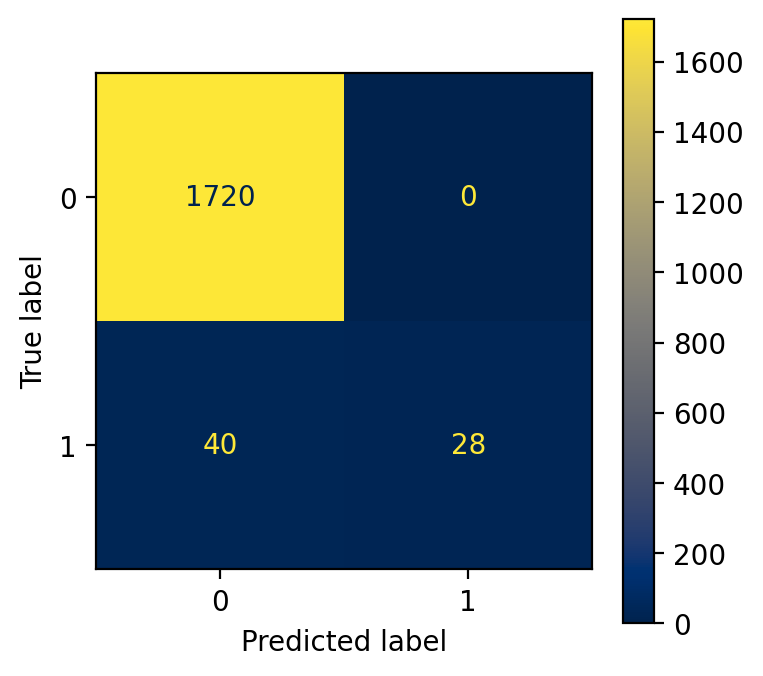

In [28]:
predicted = rfc.predict(embedded_features_val.reshape(len(df_val), -1))
print_metrics.calculate_discrete_results(target_val, predicted)

## KNN Classifier

In [29]:
knn = KNeighborsClassifier(n_neighbors=4, weights='uniform', n_jobs=-1)
knn.fit(embedded_features_train.reshape(len(df), -1), target_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=4)

Accuracy: 0.73
F1:
Micro: 0.73
Macro: 0.5
Weighted: 0.81
For fraudulent: 0.15


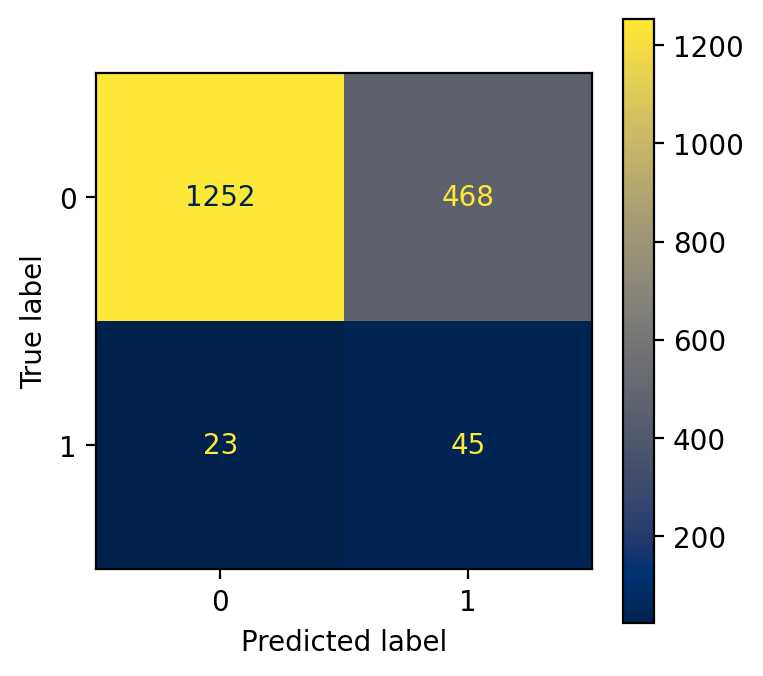

In [30]:
predicted = knn.predict(embedded_features_val.reshape(len(df_val), -1))
print_metrics.calculate_discrete_results(target_val, predicted)

## KNN Regressor

In [31]:
knn_reg = KNeighborsRegressor()
knn_reg.fit(embedded_features_train.reshape(len(df), -1), target_train)

KNeighborsRegressor()

Max threshold 0.9
Accuracy: 0.94
F1:
Micro: 0.94
Macro: 0.67
Weighted: 0.95
For fraudulent: 0.37


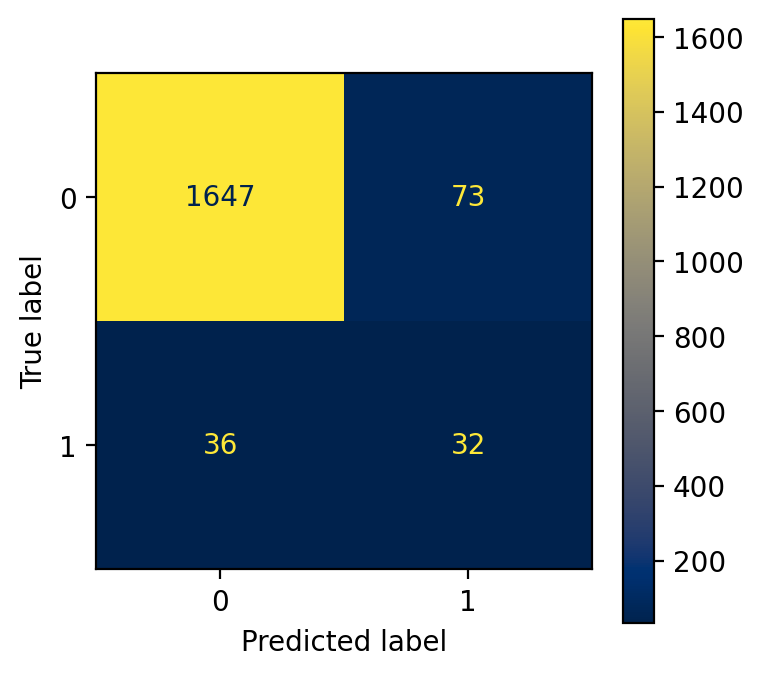

In [32]:
predicted = knn_reg.predict(embedded_features_val.reshape(len(df_val), -1))
print_metrics.calculate_analog_results(target_val, predicted)

## Linear SVC (did not work because of crash)

In [33]:
# lsvc = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))
# lsvc.fit(embedded_features_train.reshape(len(df), -1), target_train)

In [34]:
# predicted = lsvc.predict(embedded_features_val.reshape(len(df_val), -1))
# print_metrics.calculate_discrete_results(target_val, predicted)